In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

In [3]:
# Define the list of stocks
stocks = ['AAPL', 'TSLA', 'GOOGL']

# Download the stock data from Yahoo Finance
data = yf.download(stocks, start='2020-01-01', end=pd.to_datetime('today').strftime('%Y-%m-%d'))['Adj Close']


# Calculate the log of returns
log_ret = np.log(data / data.shift(1))

[*********************100%%**********************]  3 of 3 completed


In [4]:
# Create a function to calculate the Sharpe Ratio
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret / vol
    return np.array([ret, vol, sr])


In [5]:
# Create a function to check the sum of weights is 1
def check_sum(weights):
    return np.sum(weights) - 1

# Create a function to minimize the Sharpe Ratio
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]
def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2] * -1

In [28]:
# Define the constraints
cons = ({'type':'eq', 'fun': check_sum})
# Define the bounds
bounds = tuple((0, 1) for i in range(len(stocks)))
# Define the initial guess
init_guess = len(stocks) * [1 / len(stocks)]

# Run the optimizer to maximize Sharpe ratio
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)

# Run the optimizer
#opt_results = minimize(minimize_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=cons)

# Get the optimal portfolio
optimal_portfolio = get_ret_vol_sr(opt_results.x)


# Print the optimal allocation
print("Optimal allocation:")
for stock, allocation in zip(stocks, opt_results.x):
    print(f"{stock}: {allocation*100:.2f}%")

# Assign the expected return and standard deviation to variables


Optimal allocation:
AAPL: 62.44%
TSLA: 0.00%
GOOGL: 37.56%


In [14]:
# Print the optimal portfolio
print('Optimal Portfolio:')
print('Return:', optimal_portfolio[0])
print('Volatility:', optimal_portfolio[1])
print('Sharpe Ratio:', optimal_portfolio[2])

Optimal Portfolio:
Return: 0.3595438379904315
Volatility: 0.41177074878805725
Sharpe Ratio: 0.8731650780164876


In [18]:
# Monte Carlo Simulation
num_simulations = 1000
num_days = 252*30
all_weights = np.zeros((num_simulations, len(stocks)))
ret_arr = np.zeros(num_simulations)
vol_arr = np.zeros(num_simulations)
sharpe_arr = np.zeros(num_simulations)

In [19]:
for ind in range(num_simulations):
    # Create random weights
    weights = np.array(np.random.random(len(stocks)))
    weights = weights / np.sum(weights)
    
    # Save the weights
    all_weights[ind, :] = weights

    # Expected return
    ret_arr[ind] = np.sum((log_ret.mean() * weights) *252)

    # Expected volatility
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))

    # Sharpe Ratio
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

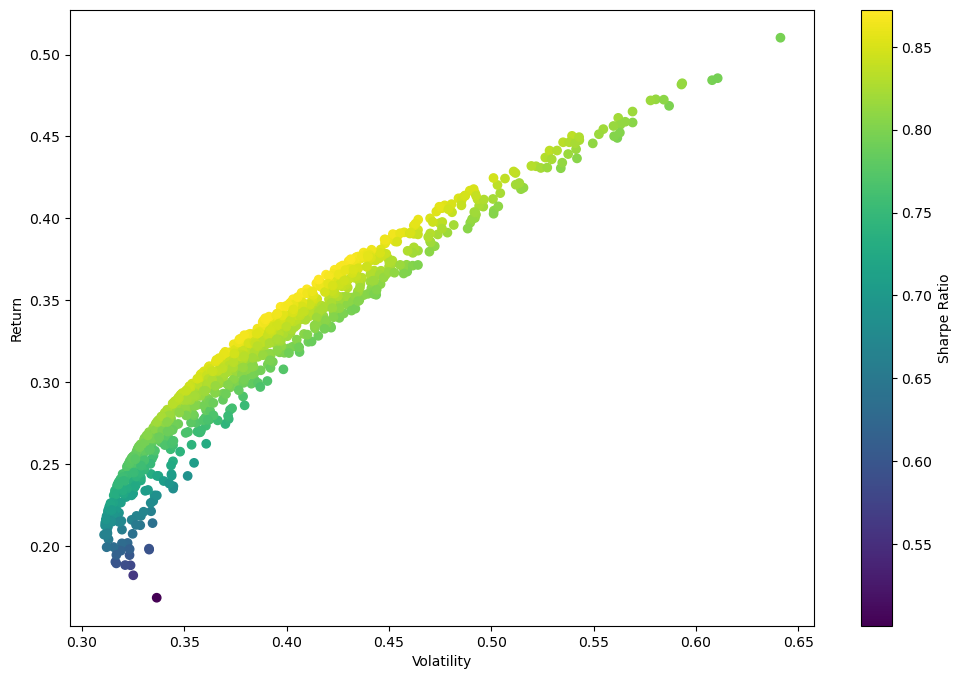

In [20]:

plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()

In [32]:

# Define the parameters
num_simulations = 10000
num_years = 20
initial_investment = 100
expected_return=optimal_portfolio[0]
print(expected_return)  
standard_deviation=optimal_portfolio[1]
mc_simulations = np.zeros((num_simulations, num_years))

for sim in range(num_simulations):
    # Calculate the log returns for each year of the simulation
    log_returns = np.random.normal(expected_return, standard_deviation, num_years)
    
    # Calculate the price for each year of the simulation
    price_list = [initial_investment]
    for x in log_returns:
        price_list.append(price_list[-1]*np.exp(x))
    
    # Save the results
    mc_simulations[sim, :] = price_list[1:]
    
   
print(price_list)

0.35641549336667006
[100, 306.9516600110247, 585.0582763950495, 583.5100298492665, 1594.9833246717944, 2528.4976482124125, 2700.4512111759855, 2244.6647187779213, 2128.4510291155334, 2512.3427595929556, 3031.235899501002, 1942.2075201848527, 4207.18803420246, 15296.924705192236, 27106.398446490075, 24486.087876107336, 22584.894402950464, 14279.941505589984, 48610.39476582634, 64955.739849685844, 128418.1738073747]


In [39]:
# Print the 25th, 50th, and 75th percentiles
print(f'25th percentile: ${np.percentile(mc_simulations[:,-1], 25)/1e3:.2f} Thousand')
print(f'50th percentile: ${np.percentile(mc_simulations[:,-1], 50)/1e3:.2f} Thousand')
print(f'75th percentile: ${np.percentile(mc_simulations[:,-1], 75)/1e3:.2f} Thousand')

25th percentile: $36.84 Thousand
50th percentile: $126.42 Thousand
75th percentile: $424.51 Thousand


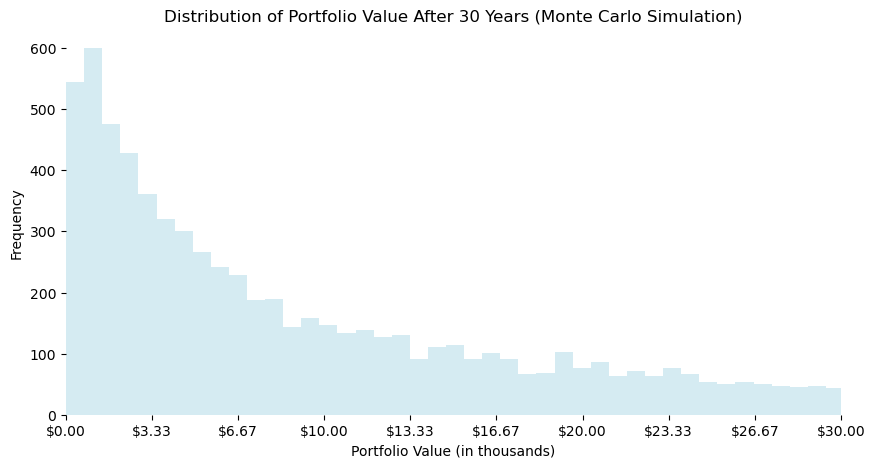

In [65]:
# Plot the results


plt.figure(figsize=(10, 5))
plt.hist(mc_simulations[:,-1], bins=10000, color='lightblue', alpha=0.5)
plt.title('Distribution of Portfolio Value After 30 Years (Monte Carlo Simulation)')
plt.ylabel('Frequency')
# Adjust the range of the x-axis

# Adjust the range of the x-axis
plt.xlim([0, np.percentile(mc_simulations[:,-1], 99)])
plt.xlim([0, 200000])  # change here
# Customize the x-axis to display more numbers
ticks = np.linspace(0, 300000, 10)
plt.xticks(ticks, [f'${tick/10e3:.2f}' for tick in ticks])

# Add a label to indicate that the x-axis values are in billions
plt.xlabel('Portfolio Value (in thousands)')

# Remove the box but leave the x and y axis
plt.box(False)

plt.show()
